In [100]:
import tensorflow as tf

import numpy as np
from numpy import asarray
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt 
from matplotlib import image

import math as m
from PIL import Image
import random

import requests as req
import csv
import os
print(os.getcwd())
from sys import getsizeof

import copy

print(tf.__version__)


/Users/babi/Documents/GitHub/Quickdraw1/training_quickdraw
2.4.0


In [2]:
def download_npy(categories,number_of_samples):

    number_of_categories = len(categories)
    data = np.array([], dtype=np.int64).reshape(0,784)
    for i in range(number_of_categories):
        filename = categories[i][0] + '.npy'
        filename = filename.replace(" ","%20")
        
        url = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'+filename
        
        r = req.get(url, allow_redirects=True)
        #filename = os.path.basename(url)
        #filename = filename.replace("%20","")
        open(filename, 'wb').write(r.content)
        
        data = np.vstack([data,load_data(filename,number_of_samples)])
        
        os.remove(filename)
        print(i+1,'/',number_of_categories,' ',filename.replace("%20",""))
    return data

def load_data(name,n):
    filename = name
    label = name
    data = np.load(filename)
    #data = np.ndarray.reshape(data,len(data),28,28)
    return data[0:n,:]

#randomize data and labels
def shuff(data,label):
    
    s = np.shape(data)
    n = s[0]
    
    l = len(label)
    label_new = np.zeros(l)
    
    if len(2*s)==2:
        d = 1
        m = 1
        data_new = np.zeros((n,m))

    elif len(2*s)==4:
        d = 2
        m = s[1]
        data_new = np.zeros((n,m))
    
    orderid = random.sample(range(n), n)
    
    #l1 = list(range(n))
    #l2 = list(range(n))
    ##Kernel dies
    #np.random.seed(seed) 
    #np.random.shuffle(l1)
    #np.random.seed(seed)
    #np.random.shuffle(l2)   
    
    for i in range(n):
        data_new[i] = data[orderid[i]]
        label_new[i] = int(label[orderid[i]])
        
    #del data, label
    return data_new, label_new

def download_and_save(number_of_categories,number_of_samples):

    x = [random.randint(0, 345) for p in range(0, number_of_categories)]

    #load categories
    categories = open("categories.txt",'r')
    reader = csv.reader(categories)
    categories = [row for row in reader]
    categories = [categories[row] for row in x]
    
    d = download_npy(categories,number_of_samples)
    
    #save Data
    filename = 'dataset/data_{}_{}.csv'.format(number_of_categories,number_of_samples)
    np.savetxt(filename, d, delimiter=',')
    
    #save Categories
    filename = 'dataset/cat_{}_{}.csv'.format(number_of_categories,number_of_samples)
    with open(filename, 'w') as f: 
        write = csv.writer(f) 
        write.writerows(categories)
    return d, categories
    
def data_from_file(number_of_categories,number_of_samples):
    
    filename = 'dataset/data_{}_{}.csv'.format(number_of_categories,number_of_samples)
    d = np.loadtxt(filename, delimiter=',')
    filename = 'dataset/cat_{}_{}.csv'.format(number_of_categories,number_of_samples)
    categories = open(filename,'r')
    reader = csv.reader(categories)
    categories = [row for row in reader]
    
    return d, categories

def predict_image(path_image):
    image = Image.open(path_image)

    image_resize = image.resize((28,28))
    image_small= asarray(image_resize)
    image_small = abs(image_small-255.)/255.
    image_small = image_small[:, :, 0]
    image_small = np.expand_dims(image_small, axis=0)
    
    predictions = model.predict(image_small)
    print(cats[np.argmax(predictions)])
    print(image_small.shape)
    plt.imshow(image_resize)
    plt.show()

In [76]:
def define_model(number_of_categories):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.Dense(number_of_categories, activation='softmax'))
    
    # compile model
    opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [49]:
a = a = np.zeros((50,10000,784));
round(getsizeof(d) / 1024 / 1024,2)

2990.72

In [67]:
ncat = 50
nsam = 10000

##load data
#d, cats = download_and_save(ncat,nsam)
d, cats = data_from_file(ncat,nsam)

cat_id = np.repeat(range(ncat),nsam)

print('Categories: ', cats)
print(np.shape(d),' ',np.shape(cat_id))


Categories:  [['cell phone'], ['stairs'], ['panda'], ['helicopter'], ['microwave'], ['underwear'], ['alarm clock'], ['postcard'], ['horse'], ['bracelet'], ['moustache'], ['flying saucer'], ['helmet'], ['frying pan'], ['sock'], ['hot dog'], ['ladder'], ['camera'], ['pineapple'], ['bottlecap'], ['fork'], ['computer'], ['see saw'], ['ambulance'], ['calculator'], ['mountain'], ['bat'], ['steak'], ['bowtie'], ['bracelet'], ['paint can'], ['church'], ['scorpion'], ['eye'], ['feather'], ['hourglass'], ['crocodile'], ['toothbrush'], ['radio'], ['underwear'], ['baseball'], ['snowflake'], ['ambulance'], ['nail'], ['flip flops'], ['parachute'], ['mountain'], ['television'], ['hamburger'], ['frog']]
(500000, 784)   (500000,)


In [68]:
#Shuffle data
data,cat_id = shuff(d,cat_id)
data_rs = np.reshape(data,(len(data),28,28))

#data to 4D
data4 = np.reshape(data,(len(data),28,28,1))

#split data
training = 0.8
test = 1.-training

x_train = data4[0:m.floor(training*len(data4))]/ 255.0
y_train = cat_id[0:m.floor(training*len(cat_id))]

x_test = data4[m.ceil(training*len(data4)):len(data4),:]/ 255.0
y_test = cat_id[m.ceil(training*len(cat_id)):len(cat_id)]

print('Train-Set: ','Samples',np.shape(x_train)[0],'/ Labels', np.shape(y_train)[0])
print('Test-Set: ','Samples',np.shape(x_test)[0],'/ Labels', np.shape(y_test)[0])

Train-Set:  Samples 400000 / Labels 400000
Test-Set:  Samples 100000 / Labels 100000


['hourglass'] 498501


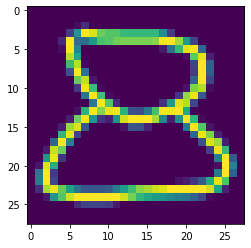

In [91]:
#TEST Show
i=random.randint(1,len(data_rs))
plt.imshow(data_rs[i])
print(cats[int(cat_id[i])],i)

In [78]:
#Model and Train
model = define_model(ncat)
history = model.fit(x_train, y_train,batch_size = 128, epochs=3)

_, acc = model.evaluate(x_test,  y_test, verbose=2);

print('Accuracy > %.3f' % (acc * 100.0))

# stores scores
scores, histories = list(), list()
scores.append(acc)
histories.append(history)

Epoch 1/3
3125/3125 [==============================] - 128s 41ms/step - loss: 1.6688 - accuracy: 0.5533
Epoch 2/3
3125/3125 [==============================] - 109s 35ms/step - loss: 0.9519 - accuracy: 0.7184
Epoch 3/3
3125/3125 [==============================] - 117s 37ms/step - loss: 0.8596 - accuracy: 0.7392
3125/3125 - 8s - loss: 0.8817 - accuracy: 0.7347
Accuracy > 73.475


['toothbrush']


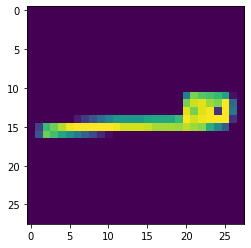

In [79]:
#Test Predictions
predictions = model.predict(x_test)

i=random.randint(1,len(x_test))
x_test_0 = np.reshape(x_test[i],(28,28))
plt.imshow(x_test_0)
print(cats[np.argmax(predictions[i])])


['panda'] [2]
['mountain'] 25


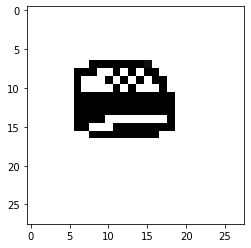

In [98]:
##Predict
#labels = open("dataset/cat_50_10000.csv",'r')
#reader = csv.reader(labels)
#labels = [row for row in reader]

image = Image.open('dataset/hamburger.png')
data_resize = image.resize((28,28))
data_resize = asarray(data_resize)
data4 = np.reshape(data_resize,(-1,28,28,4))
data4_ = data_resize.reshape(-1, 28,28, 1)

plt.imshow(data4[0])
p = model.predict(data4_)
print(cats[np.argmax(p)], [np.argmax(p)])
print(cats[int(cat_id[np.argmax(p)])],  int(cat_id[np.argmax(p)]))


In [83]:
cat_id

array([ 3., 21., 25., ..., 37.,  2., 26.])

In [87]:
np.argmax(p)

2

In [89]:
cat_id[2]

25.0

In [90]:
cats[25]

['mountain']

In [92]:
cats[int(cat_id[np.argmax(p)])]

['mountain']

dict_keys(['loss', 'accuracy'])


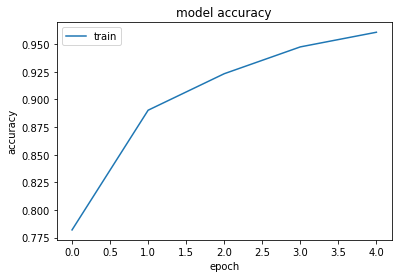

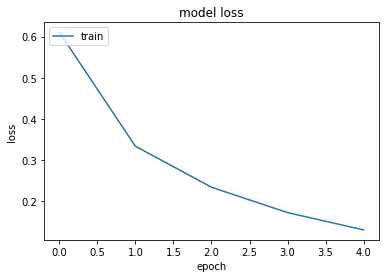

In [38]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [59]:
name = "qd_cnn_50_10000.h5"
saved_model_dir = 'save/'+str(name)
model.save(saved_model_dir)
print('Model Saved to '+saved_model_dir)

Model Saved to save/qd_cnn_50_10000.h5
